## 1. Two-dimensional data

In [27]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from scipy.stats import multivariate_normal
import numpy as np

### 1. Two-dimensional Histogram

In [28]:
class Histogram2D:
    def __init__(self, bins=20, range=None):
        self.bins = bins
        self.range = range

    def fit(self, X):
        hist, x_edges, y_edges = np.histogram2d(X[:,0], X[:,1],
                                                bins=self.bins,
                                                range=self.range)
        
        self.hist = hist / np.sum(hist)  
        self.x_edges = x_edges
        self.y_edges = y_edges
        
        self.hx = x_edges[1] - x_edges[0]
        self.hy = y_edges[1] - y_edges[0]
        return self

    def sample(self, n_samples):
        probs = self.hist.flatten()
        probs /= np.sum(probs)

        idx = np.random.choice(len(probs), size=n_samples, p=probs)
        ix = idx // self.bins
        iy = idx % self.bins

        xs = self.x_edges[ix] + np.random.rand(n_samples) * self.hx
        ys = self.y_edges[iy] + np.random.rand(n_samples) * self.hy
        
        samples = np.stack([xs, ys], axis=1)
        return samples

    def score_samples(self, X):
        ix = np.searchsorted(self.x_edges, X[:,0], side='right') - 1
        iy = np.searchsorted(self.y_edges, X[:,1], side='right') - 1
        
        ix = np.clip(ix, 0, self.bins - 1)
        iy = np.clip(iy, 0, self.bins - 1)

        probs = self.hist[ix, iy]

        probs = np.maximum(probs, 1e-12)
        logp = np.log(probs)
        
        return logp


### 2. Single Gaussian

In [29]:
class SingleGaussian:
    def __init__(self):
        self.mean = None
        self.cov = None
    
    def fit(self, X):
        self.mean = np.mean(X, axis=0)
        diff = X - self.mean
        self.cov = np.cov(diff.T, bias=True)
        return self
    
    def sample(self, n_samples):
        samples = np.random.multivariate_normal(self.mean, self.cov, size=n_samples)
        return samples
    
    def score_samples(self, X):
        # log p(x) = -1/2 [ (x-μ)^T Σ^{-1} (x-μ) + log|Σ| + D*log(2π) ]
        D = X.shape[1]
        diff = X - self.mean
        inv_cov = np.linalg.inv(self.cov)
        det_cov = np.linalg.det(self.cov)
        exp_term = np.einsum('ij,jk,ik->i', diff, inv_cov, diff)
        logp = -0.5 * (exp_term + np.log(det_cov) + D * np.log(2 * np.pi))
        
        return logp

### 3. GMM（Gaussian Mixture Model）

In [30]:

class GMM:
    def __init__(self, n_components=3, max_iter=100, tol=1e-4, seed=0):
        self.K = n_components      
        self.max_iter = max_iter   
        self.tol = tol
        self.seed = seed 
    
    def fit(self, X):
        rng = np.random.default_rng(self.seed)
        N, D = X.shape
        
        np.random.seed(0)
        self.pi = np.ones(self.K) / self.K
        self.mu = X[np.random.choice(N, self.K, replace=False)]
        self.sigma = np.array([np.cov(X.T) for _ in range(self.K)])
        
        log_likelihood_old = 0

        for step in range(self.max_iter):
            # E-step
            gamma = np.zeros((N, self.K))
            for k in range(self.K):
                rv = multivariate_normal(mean=self.mu[k],cov=self.sigma[k],allow_singular=True)
                gamma[:, k] = self.pi[k] * rv.pdf(X)
            gamma /= np.sum(gamma, axis=1, keepdims=True)

            # M-step
            Nk = np.sum(gamma, axis=0)
            self.pi = Nk / N
            self.mu = (gamma.T @ X) / Nk[:, np.newaxis]
            self.sigma = np.zeros((self.K, D, D))
            for k in range(self.K):
                diff = X - self.mu[k]
                self.sigma[k] = (gamma[:, k][:, np.newaxis] * diff).T @ diff / Nk[k]
                self.sigma[k] = 0.5*(self.sigma[k] + self.sigma[k].T)
                self.sigma[k] += 1e-6*np.eye(D) 

            log_likelihood = np.sum(np.log(np.sum([
                self.pi[k] * multivariate_normal.pdf(X, self.mu[k], self.sigma[k])
                for k in range(self.K)
            ], axis=0)))
            if abs(log_likelihood - log_likelihood_old) < self.tol:
                break
            log_likelihood_old = log_likelihood
        return self
    
    def sample(self, n_samples):
        component = np.random.choice(self.K, size=n_samples, p=self.pi)
        samples = np.array([
            np.random.multivariate_normal(self.mu[k], self.sigma[k])
            for k in component
        ])
        return samples
    
    def score_samples(self, X):
        pdf = np.sum([
            self.pi[k] * multivariate_normal.pdf(X, self.mu[k], self.sigma[k])
            for k in range(self.K)
        ], axis=0)
        return np.log(pdf + 1e-12)

### 4. KDE (Kernel Density Estimation) with a Gaussian Kernel

In [31]:
class GaussianKDE:
    def __init__(self, bandwidth=0.2):
        self.bandwidth = bandwidth
        self.X_train = None
        self.N = None
        self.D = None

    def fit(self, X):
        self.X_train = X
        self.N, self.D = X.shape
        return self

    def score_samples(self, X):
        h = self.bandwidth
        N, D = self.N, self.D
        Xq = X[:, None, :]            
        Xtrain = self.X_train[None, :, :] 

        diff = Xq - Xtrain            
        dist2 = np.sum(diff**2, axis=2)  

        kernel_vals = np.exp(-0.5 * dist2 / (h**2))

        norm_const = (2 * np.pi)**(D/2) * (h**D) * N
        p = np.sum(kernel_vals, axis=1) / norm_const

        return np.log(p + 1e-12)  

    def sample(self, n_samples):
        idx = np.random.choice(self.N, size=n_samples, replace=True)
        centers = self.X_train[idx]
        noise = np.random.randn(n_samples, self.D) * self.bandwidth
        return centers + noise

In [32]:
import numpy as np

def _pdist2(X, Y):
    XX = (X**2).sum(1, keepdims=True)
    YY = (Y**2).sum(1, keepdims=True).T
    d2 = XX + YY - 2 * X @ Y.T
    return np.maximum(d2, 0.0) 

def mmd2_unbiased(X, Y, h=1.0, kernel='se'):
    n, m = len(X), len(Y)
    dxx = _pdist2(X, X)
    dyy = _pdist2(Y, Y)
    dxy = _pdist2(X, Y)

    if kernel == 'se':        
        Kxx = np.exp(-dxx/(h*h))
        Kyy = np.exp(-dyy/(h*h))
        Kxy = np.exp(-dxy/(h*h))
    elif kernel == 'imq':    
        Kxx = 1.0/np.sqrt(1.0 + dxx/(h*h))
        Kyy = 1.0/np.sqrt(1.0 + dyy/(h*h))
        Kxy = 1.0/np.sqrt(1.0 + dxy/(h*h))
    else:
        raise ValueError("kernel must be 'se' or 'imq'")

    np.fill_diagonal(Kxx, 0.0)
    np.fill_diagonal(Kyy, 0.0)

    term_x = Kxx.sum()/(n*(n-1))
    term_y = Kyy.sum()/(m*(m-1))
    term_xy = 2.0*Kxy.mean()
    return term_x + term_y - term_xy

def median_heuristic(X, max_n=800):
    idx = np.random.choice(len(X), size=min(max_n, len(X)), replace=False)
    Z = X[idx]
    d2 = _pdist2(Z, Z)
    med = np.median(d2[np.triu_indices_from(d2, k=1)])
    return np.sqrt(0.5*med)

In [33]:
def make_data(n, noise=0.1, seed=0):
    X, _ = make_moons(n_samples=n, noise=noise, random_state=seed)
    return X.astype(float)

X_test = make_data(2000, noise=0.1, seed=123)

train_sizes = [100, 200, 500, 1000]
hist_bins_list = [10, 20, 30, 50, 80]
K_list = [1, 2, 3, 5, 8, 12]
kde_bandwidth_list = [0.05, 0.1, 0.2, 0.3]

def plot_curves(results_dict, title):
    """
    results_dict: {label: {"x": list_sizes, "y": list_values}}
    """
    for label, d in results_dict.items():
        plt.plot(d["x"], d["y"], marker="o", label=label)
    plt.xlabel("Train size")
    plt.ylabel("MMD$^2$")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

def eval_hist_over_bins(train_size, bins_list, kernel="se", R=5, fixed_range=None, h_fixed=0.12):
    Xtr_list = [make_data(train_size, noise=0.1, seed=12345+r) for r in range(R)]
    mmds = []
    for b in bins_list:
        vals = []
        for r in range(R):
            X_train = Xtr_list[r]
            model = Histogram2D(bins=b, range=fixed_range).fit(X_train)
            X_gen = model.sample(2000)                 
            vals.append(mmd2_unbiased(X_test, X_gen, h=h_fixed, kernel=kernel))
        mmds.append(float(np.mean(vals)))
    return {"x": bins_list, "y": mmds, "label": f"n={train_size}", "kernel": kernel}


def plot_results_group_bins(group, title_prefix):
    for ker in ("se", "imq"):
        subset = [g for g in group if g["kernel"] == ker]
        results = {g["label"]: {"x": g["x"], "y": g["y"]} for g in subset}
        for label, d in results.items():
            plt.plot(d["x"], d["y"], marker="o", label=label)
        plt.xlabel("bins")
        plt.ylabel("MMD$^2$")
        plt.title(f"{title_prefix} — {ker.upper()} kernel")
        plt.legend()
        plt.tight_layout()
        plt.show()


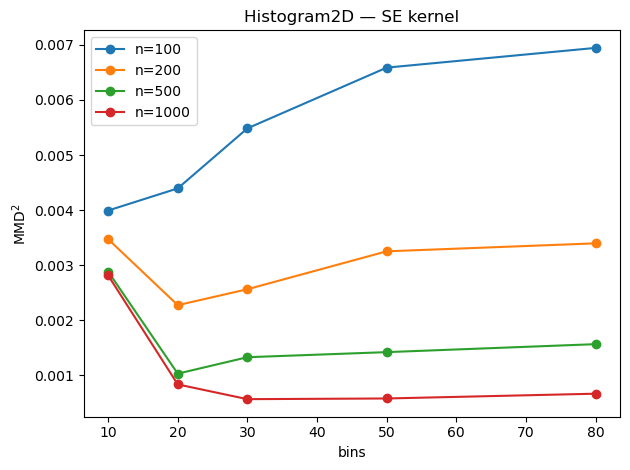

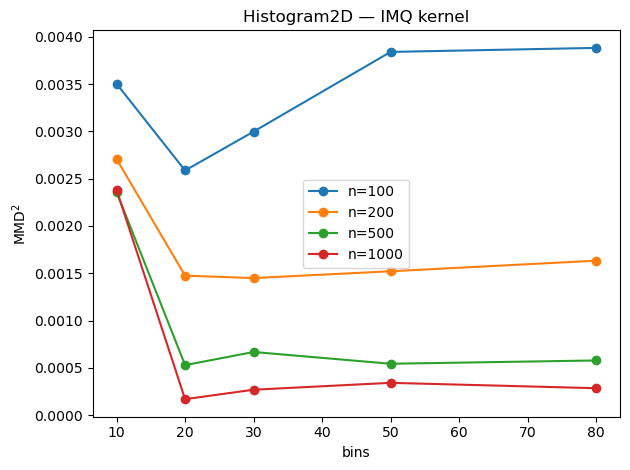

In [34]:
h_fixed = 0.12
pad = 0.2
fixed_range = [(X_test[:,0].min()-pad, X_test[:,0].max()+pad),
               (X_test[:,1].min()-pad, X_test[:,1].max()+pad)]

all_hist = []
for n in train_sizes:
    all_hist.append(eval_hist_over_bins(n, hist_bins_list, kernel="se",  R=5,
                                        fixed_range=fixed_range, h_fixed=h_fixed))
    all_hist.append(eval_hist_over_bins(n, hist_bins_list, kernel="imq", R=5,
                                        fixed_range=fixed_range, h_fixed=h_fixed))
plot_results_group_bins(all_hist, "Histogram2D")



### Histogram2D — SE kernel

For all training sizes, MMD² drops markedly when we move from 10 to 20 bins and then increases again as the grid gets finer (30–80). Larger training sets consistently achieve lower MMD² across the entire range.

The initial improvement (10 → 20 bins) reflects reduced bias: a very coarse grid cannot capture the curved “two-moons” structure. Beyond 20 bins, variance dominates: many bins become sparsely populated or empty, so the histogram sample generator picks bins that do not represent the test distribution well, which pushes MMD² up. With more data, the variance penalty is smaller, hence the shallower increase.

### Histogram2D — IMQ kernel

The overall pattern matches the SE plot: a clear drop between 10 and 20 bins, followed by a mild increase as the grid is refined. Absolute MMD² values are smaller than with SE.

The IMQ kernel weights larger pairwise distances more heavily and is less sensitive to very local misalignments than SE. Consequently, the variance introduced by many tiny bins hurts slightly less in IMQ, hence the lower scale.

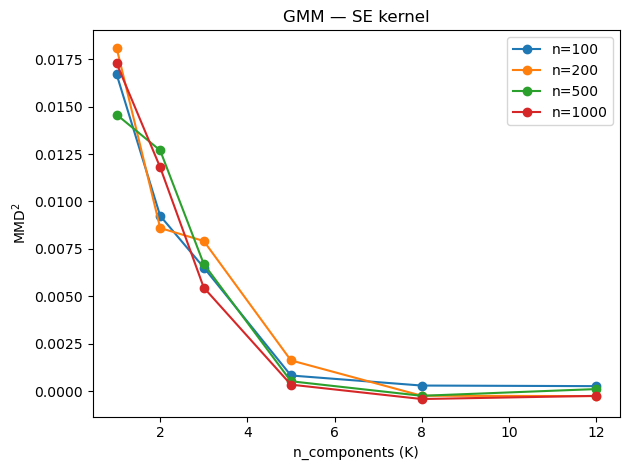

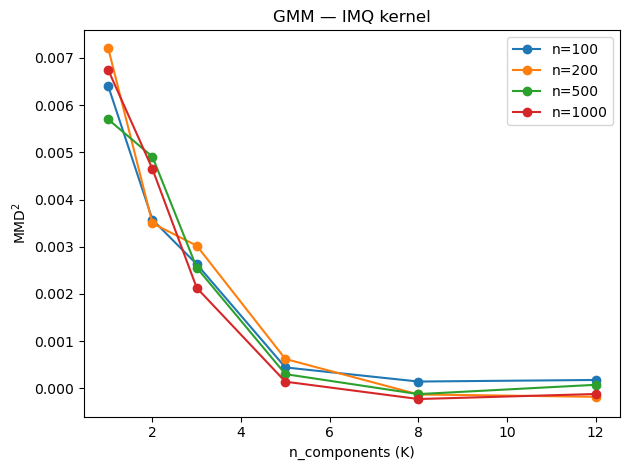

In [35]:
def eval_gmm_over_components(train_size, k_list, kernel="se",
                             R=5, h_fixed=None, seed_base=24680, ngen=2000):
  
    Xtr_list = [make_data(train_size, noise=0.1, seed=seed_base + r) for r in range(R)]

    mmds = []
    for K in k_list:
        vals = []
        for r in range(R):
            X_train = Xtr_list[r]
            model = GMM(n_components=K, seed=0).fit(X_train)
            X_gen = model.sample(ngen)
            h = h_fixed if h_fixed is not None else median_heuristic(np.vstack([X_test, X_gen]))
            vals.append(mmd2_unbiased(X_test, X_gen, h=h, kernel=kernel))
        mmds.append(float(np.mean(vals)))
    return {"x": k_list, "y": mmds, "label": f"n={train_size}", "kernel": kernel}

def plot_results_group_components(group, title_prefix):
    for ker in ("se", "imq"):
        subset = [g for g in group if g["kernel"] == ker]
        results = {g["label"]: {"x": g["x"], "y": g["y"]} for g in subset}
        for label, d in results.items():
            plt.plot(d["x"], d["y"], marker="o", label=label)
        plt.xlabel("n_components (K)")
        plt.ylabel("MMD$^2$")
        plt.title(f"{title_prefix} — {ker.upper()} kernel")
        plt.legend()
        plt.tight_layout()
        plt.show()


h_fixed = median_heuristic(X_test)  

all_gmm = []
for n in train_sizes: 
    all_gmm.append(eval_gmm_over_components(n, K_list, kernel="se",  R=5, h_fixed=h_fixed))
    all_gmm.append(eval_gmm_over_components(n, K_list, kernel="imq", R=5, h_fixed=h_fixed))

plot_results_group_components(all_gmm, "GMM")



### GMM — SE kernel

MMD² decreases steeply as the number of components grows from 1 to 5, then flattens around zero (and even dips slightly below zero) for K ≥ 6–12. Larger training sets yield slightly better optima.

A single Gaussian cannot model the two-moon geometry. Increasing K reduces bias by allowing a multi-modal approximation; after 5 components the mixture is flexible enough to closely match the target, and additional components bring diminishing returns. Tiny negative values are again consistent with an unbiased MMD² estimate around the optimum.

### GMM — IMQ kernel
Same qualitative behavior as with SE, at a smaller numerical scale. The optimum is reached around K≈6–8, after which the curve is essentially flat.

IMQ’s heavier tail makes it slightly more tolerant to local overfitting; hence the very low (sometimes negative) MMD² once K is sufficient.

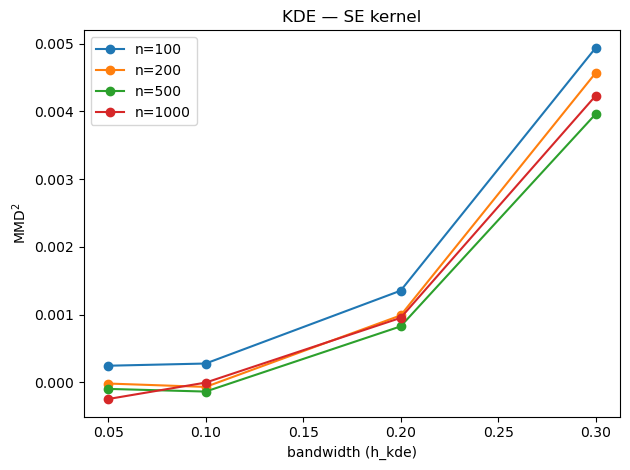

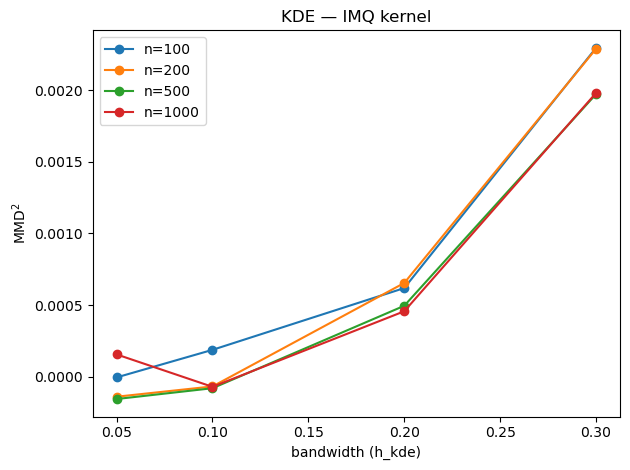

In [36]:
def eval_kde_over_bandwidth(train_size, bw_list, kernel="se",
                            R=5, seed_base=31415, ngen=2000,
                            h_mmd_fixed=None):
    Xtr_list = [make_data(train_size, noise=0.1, seed=seed_base + r) for r in range(R)]

    mmds = []
    for h_kde in bw_list:
        vals = []
        for r in range(R):
            X_train = Xtr_list[r]
            model = GaussianKDE(bandwidth=h_kde).fit(X_train)
            X_gen = model.sample(ngen)
            h_mmd = h_mmd_fixed if h_mmd_fixed is not None else median_heuristic(np.vstack([X_test, X_gen]))
            vals.append(mmd2_unbiased(X_test, X_gen, h=h_mmd, kernel=kernel))
        mmds.append(float(np.mean(vals)))
    return {"x": bw_list, "y": mmds, "label": f"n={train_size}", "kernel": kernel}

def plot_results_group_bandwidth(group, title_prefix):
    for ker in ("se", "imq"):
        subset = [g for g in group if g["kernel"] == ker]
        results = {g["label"]: {"x": g["x"], "y": g["y"]} for g in subset}
        for label, d in results.items():
            plt.plot(d["x"], d["y"], marker="o", label=label)
        plt.xlabel("bandwidth (h_kde)")
        plt.ylabel("MMD$^2$")
        plt.title(f"{title_prefix} — {ker.upper()} kernel")
        plt.legend()
        plt.tight_layout()
        plt.show()


bw_list = kde_bandwidth_list                     
h_mmd_fixed = median_heuristic(X_test)           

all_kde = []
for n in train_sizes:
    all_kde.append(eval_kde_over_bandwidth(n, bw_list, kernel="se",  R=5, h_mmd_fixed=h_mmd_fixed))
    all_kde.append(eval_kde_over_bandwidth(n, bw_list, kernel="imq", R=5, h_mmd_fixed=h_mmd_fixed))

plot_results_group_bandwidth(all_kde, "KDE")


### KDE — SE kernel

MMD² increases monotonically with the bandwidth h (0.05 → 0.30). The best region is at the smallest bandwidths; larger n helps but does not invert the trend.

The moons distribution has thin, curved structures. Small bandwidths capture these manifolds; large bandwidths oversmooth and fill the gap between the moons, producing samples that deviate from the test set, hence larger MMD². With more data, even small h remains stable (variance drops), so the curves for larger n stay low near h=0.05–0.10.

### KDE — IMQ kernel

The same monotone increase with bandwidth appears, with slightly smaller magnitudes than SE. For n=1000 and small h the estimates hover around zero and can be marginally negative.

Identical to the SE case: oversmoothing harms alignment with the moon geometry; IMQ’s wider sensitivity range lowers the overall scale and masks some local discrepancies.

In [37]:

def sanity_check_sg_vs_gmm1(train_sizes, h_fixed=None, R=5, ngen=2000, kernel="se"):
    if h_fixed is None:
        h_fixed = median_heuristic(X_test)
    diffs = []
    for n in train_sizes:
        vals = []
        for r in range(R):
            X_train = make_data(n, noise=0.1, seed=10_000*n + r)
            sg  = SingleGaussian().fit(X_train)
            g1  = GMM(n_components=1).fit(X_train)
            XgA = sg.sample(ngen);  mmdA = mmd2_unbiased(X_test, XgA, h=h_fixed, kernel=kernel)
            XgB = g1.sample(ngen);  mmdB = mmd2_unbiased(X_test, XgB, h=h_fixed, kernel=kernel)
            vals.append(abs(mmdA - mmdB))
        diffs.append((n, float(np.mean(vals))))
    return diffs

print(sanity_check_sg_vs_gmm1(train_sizes, kernel="se"))
print(sanity_check_sg_vs_gmm1(train_sizes, kernel="imq"))


[(100, 0.0006686948435118634), (200, 0.0010291972593730492), (500, 0.0013059714436334025), (1000, 0.00031216550074522067)]
[(100, 0.000273534787215679), (200, 0.00038382705668973396), (500, 0.00023641252889730068), (1000, 0.0002120047491441568)]


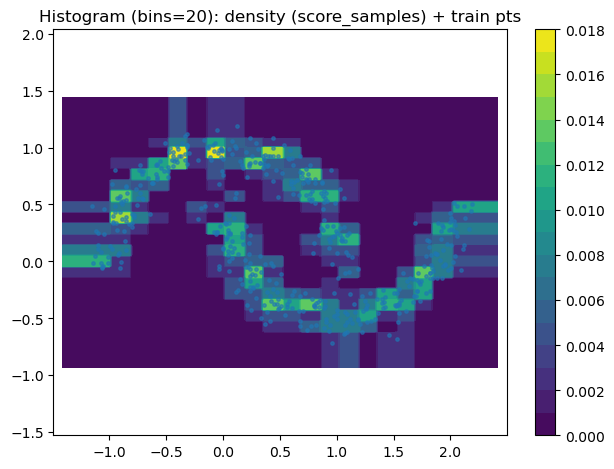

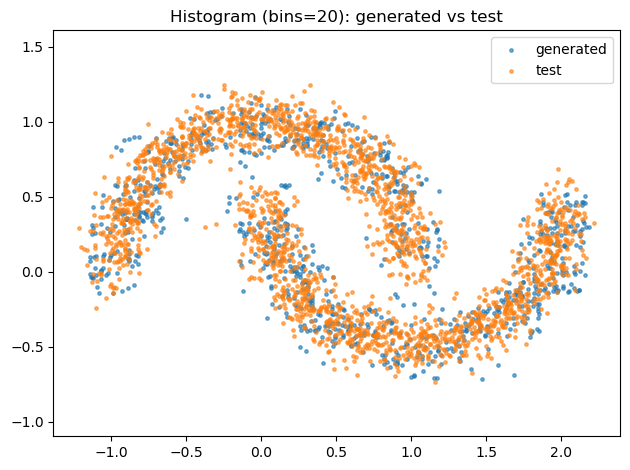

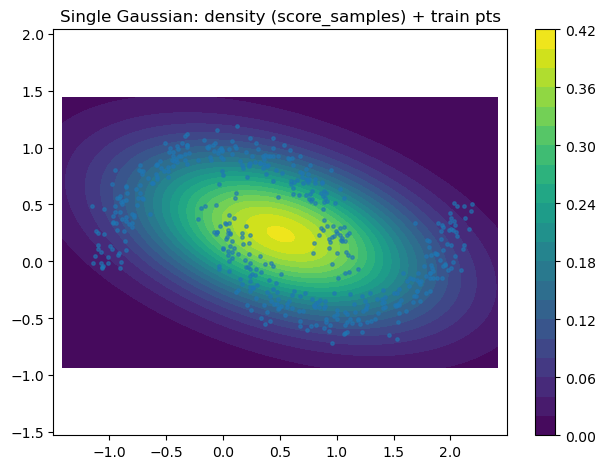

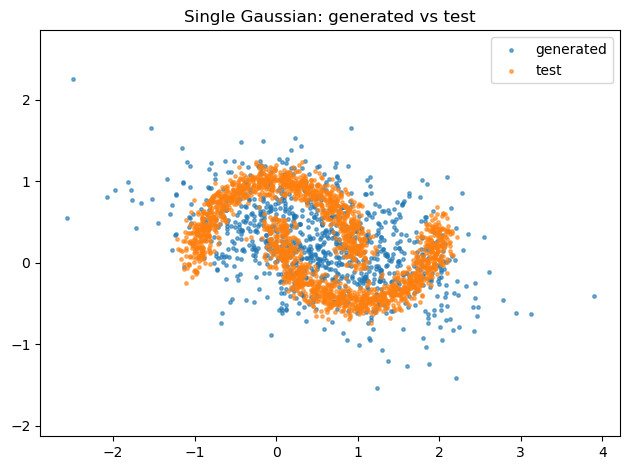

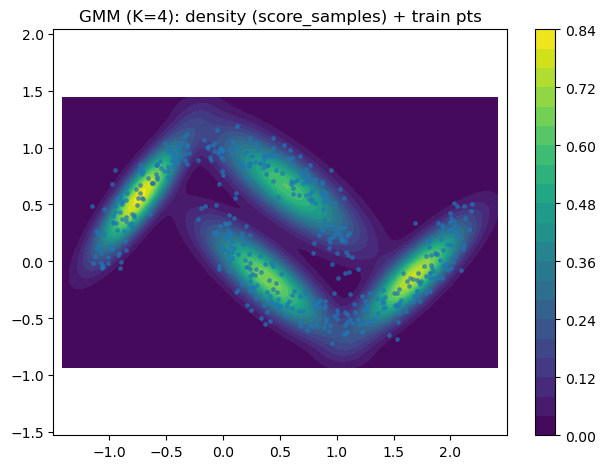

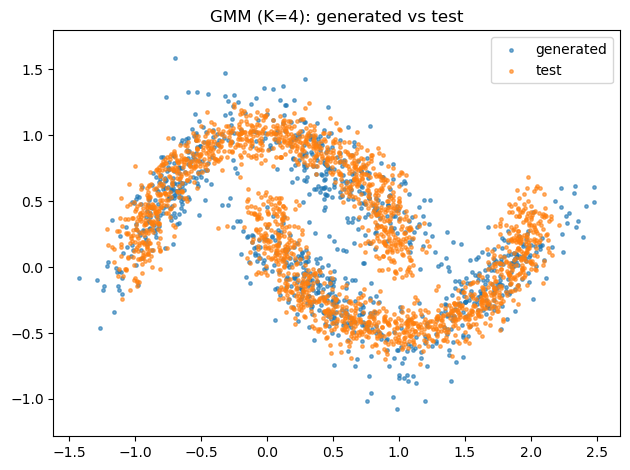

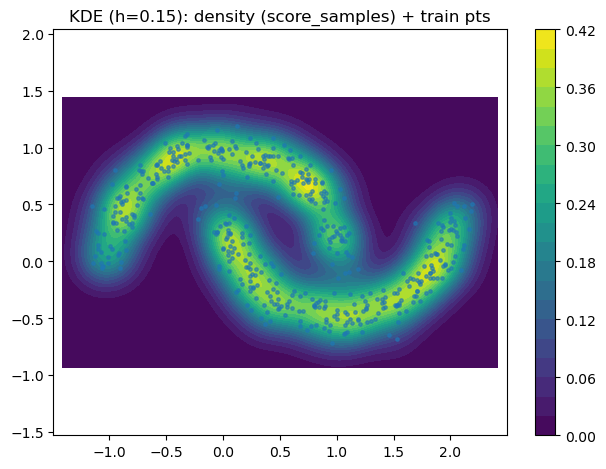

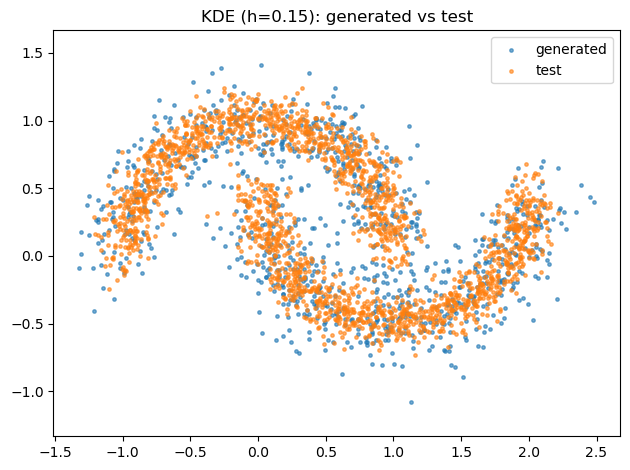

In [38]:
def make_grid(X, n=150, pad=0.2):
    lo = X.min(axis=0) - pad
    hi = X.max(axis=0) + pad
    xs = np.linspace(lo[0], hi[0], n)
    ys = np.linspace(lo[1], hi[1], n)
    GX, GY = np.meshgrid(xs, ys)
    G = np.column_stack([GX.ravel(), GY.ravel()])
    return xs, ys, GX, GY, G

def visualize_model(model, X_train, n_gen=1000, title="Model"):
    xs, ys, GX, GY, G = make_grid(np.vstack([X_train, X_test]))
    Z = np.exp(model.score_samples(G)).reshape(GX.shape)

    plt.contourf(GX, GY, Z, levels=20)
    plt.colorbar()
    plt.scatter(X_train[:, 0], X_train[:, 1], s=6, alpha=0.6)
    plt.axis("equal")
    plt.title(f"{title}: density (score_samples) + train pts")
    plt.tight_layout()
    plt.show()

    X_gen = model.sample(n_gen)
    plt.scatter(X_gen[:, 0], X_gen[:, 1], s=6, alpha=0.6, label="generated")
    plt.scatter(X_test[:, 0], X_test[:, 1], s=6, alpha=0.6, label="test")
    plt.axis("equal")
    plt.legend()
    plt.title(f"{title}: generated vs test")
    plt.tight_layout()
    plt.show()


X_tr = make_data(500, noise=0.1, seed=7)

models_show = [
    ("Histogram (bins=20)", Histogram2D(bins=20).fit(X_tr)),
    ("Single Gaussian",     SingleGaussian().fit(X_tr)),
    ("GMM (K=4)",           GMM(n_components=4, seed=0).fit(X_tr)),
    ("KDE (h=0.15)",         GaussianKDE(bandwidth=0.15).fit(X_tr)),
]

for name, mdl in models_show:
    visualize_model(mdl, X_tr, title=name)


### Histogram (bins=20): density (score_samples) + train points

The piecewise-constant nature of the 2D histogram is visible: density blocks align with grid cells and create jagged boundaries. Still, the model captures the two arcs fairly well at this resolution.

### Histogram (bins = 20): generated vs test

Generated samples broadly follow the moons and match the global shape.Small clumps near bin edges and a few tiny gaps reflect uniform sampling inside selected bins.

### Single Gaussian: density (score_samples) + train points

Contours are elliptical and fill the central gap, which contradicts the bimodal curved structure of the moons. This shows strong model bias: a single Gaussian cannot represent the non-elliptical, multi-modal geometry.

### Single Gaussian: generated vs test

Samples concentrate in the middle and spill between the two arcs, clearly misaligning with the test set. This is a bad model and explains the large MMD² obtained for K=1 vs the moons.

### GMM (K = 4): density (score_samples) + train points

Multiple elongated components start to trace the arcs and carve out the low-density gap. Some leakage remains between the moons and at the tips, but the global pattern is largely correct. Increasing K typically tightens the fit.

### GMM (K = 4): generated vs test

Generated points align closely with the test set. In the MMD² curves the optimum appears around K≈6–8, where these residual errors further diminish.

### KDE (h = 0.15): density (score_samples) + train points

Gaussian KDE produces a smooth density that follows the curved manifolds and maintains the central gap. With this bandwidth the bias–variance trade-off is favorable.

### KDE (h = 0.15): generated vs test

Generated samples are almost indistinguishable from the test points. Among the four models, KDE with a small h gives the best visual match.

## 2. Higher-dimensional data

In [39]:
from sklearn.datasets import load_digits
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KernelDensity
from sklearn.ensemble import RandomForestClassifier
from joblib import Parallel, delayed

In [40]:
rng = np.random.RandomState(42)  
digits = load_digits()
X_train, y_train = digits.data, digits.target
n_features = X_train.shape[1]
test_size = 2000  

gmm_components = [1, 2, 3, 4, 5, 7, 10, 15, 20, 30, 50, 100]
kde_bandwidths = [0.001, 0.002, 0.005, 0.0075, 0.01, 0.02, 0.05, 0.075, 0.1, 1, 2]
n_mins = [5, 10, 20, 50, 100, 200]

mmd_results = {
    'GMM': {'parameters': [] , 'mmd_se': [], 'mmd_imq': [], 'model': []},
    'KDE': {'parameters': [], 'mmd_se': [], 'mmd_imq': [], 'model': []},
    'DF' : {'parameters': [], 'mmd_se': [], 'mmd_imq': [], 'model': []}
}

class Node: ...

class DensityTree:
    def __init__(self, n_min=10):
        self.n_min = n_min 
        self.kernal = {'count': [], 'mean': [], 'cov': []}
        
    def fit(self, features, D_try=None):
        N, D = features.shape
        if D_try is None:
            D_try = int(np.sqrt(D))  
        
        self.root = Node(); self.root.features = features
        stack = [self.root]
        while stack:
            node = stack.pop()
            active_indices = self.select_active_indices(D, D_try)
            left, right = self.make_split_node(node, active_indices)
            if left is None:  
                self.make_leaf_node(node)
            else:
                stack.extend([left, right])
        
        self.weights_ = np.array(self.kernal['count'], dtype=float)
        self.weights_ = self.weights_ / self.weights_.sum()
        self.means_ = np.array(self.kernal['mean'])
        self.covariances_ = np.array(self.kernal['cov'])
        self.n_components = self.weights_.shape[0]
    
    def make_split_node(self, node, indices):
        l_min = float('inf'); j_min = None; t_min = None
        for j in indices:
            thresholds = self.find_thresholds(node, j)
            for t in thresholds:
                loss = self.compute_loss_for_split(node, j, t)
                if loss < l_min:
                    l_min, j_min, t_min = loss, j, t
        if j_min is None:
            return None, None
        left, right = self.make_children(node, j_min, t_min)
        node.left, node.right = left, right
        node.split_index, node.threshold = j_min, t_min
        return left, right
    
    def select_active_indices(self, D, D_try):
        return rng.choice(np.arange(D), size=D_try, replace=False)
        
    def find_thresholds(self, node, j):
        if node.features.shape[0] < 2*self.n_min:
            return []
        sort = np.sort(node.features[:, j])
        t = (sort[:-1] + sort[1:]) / 2
        if self.n_min > 1:
            t = t[(self.n_min-1): (-self.n_min+1)]
        return t
        
    def make_children(self, node, j, t):
        left = Node(); right = Node()
        left.features  = node.features[node.features[:, j] <= t]
        right.features = node.features[node.features[:, j] >  t]
        return left, right
    
    def entropy_gaussian(self, features):
        cov = np.cov(features.T)
        cov = cov + 1e-6*np.eye(cov.shape[0])
        sign, logdet = np.linalg.slogdet(cov)
        if sign <= 0:  
            return float('inf')
        # H(N(μ,Σ)) = 0.5 * log((2πe)^d detΣ)
        d = features.shape[1]
        return 0.5 * (d*np.log(2*np.pi*np.e) + logdet)

    def compute_loss_for_split(self, node, j, t):
        l_resp = node.features[node.features[:, j] <= t]
        r_resp = node.features[node.features[:, j] >  t]
        if (l_resp.shape[0] < self.n_min) or (r_resp.shape[0] < self.n_min):
            return float('inf')
        return self.entropy_gaussian(l_resp) + self.entropy_gaussian(r_resp)
        
    def make_leaf_node(self, node):
        self.kernal['count'].append(node.features.shape[0])
        self.kernal['mean'].append(node.features.mean(0))
        cov = np.cov(node.features.T) + 1e-6*np.eye(node.features.shape[1])
        self.kernal['cov'].append(cov)

    def sample(self, n_samples):
        idx = rng.choice(self.n_components, size=n_samples, p=self.weights_)
        chunks = []
        for k in range(self.n_components):
            n_k = np.sum(idx == k)
            if n_k:
                chunks.append(rng.multivariate_normal(self.means_[k], self.covariances_[k], size=n_k))
        samples = np.vstack(chunks)
        rng.shuffle(samples)
        return samples

def bootstrap_sampling(features):
    N = features.shape[0]
    inds = rng.choice(N, N, replace=True)
    return features[inds]


In [41]:
class DensityForest:
    def __init__(self, n_trees=10, n_min=10):
        self.n_trees = n_trees
        self.trees = [DensityTree(n_min) for _ in range(n_trees)]

    def fit(self, features):
        self.trees = Parallel(n_jobs=-1)(
            delayed(self._fit_tree)(tree, features) for tree in self.trees
        )

    def _fit_tree(self, tree, features):
        tree.fit(bootstrap_sampling(features))
        return tree
    
    def sample(self, n_samples):
        # 先按树均匀抽，再在每棵树内用其叶GMM采样
        idx = rng.choice(self.n_trees, size=n_samples)
        chunks = []
        for t, tree in enumerate(self.trees):
            n_k = np.sum(idx == t)
            if n_k:
                chunks.append(tree.sample(n_k))
        samples = np.vstack(chunks)
        rng.shuffle(samples)
        return samples

In [ ]:
for n_comp in gmm_components:
    gmm = GaussianMixture(n_components=n_comp, init_params='k-means++', random_state=42)
    gmm.fit(X_train)
    samples, _ = gmm.sample(test_size)
    mmd_se  = mmd2_unbiased(samples, X_train, h=1.0, kernel='se')
    mmd_imq = mmd2_unbiased(samples, X_train, h=1.0, kernel='imq')
    mmd_results['GMM']['parameters'].append(n_comp)
    mmd_results['GMM']['mmd_se'].append(float(mmd_se))
    mmd_results['GMM']['mmd_imq'].append(float(mmd_imq))
    mmd_results['GMM']['model'].append(gmm)

for bw in kde_bandwidths:
    kde = KernelDensity(kernel='gaussian', bandwidth=bw)
    kde.fit(X_train)
    samples = kde.sample(test_size, random_state=42)
    mmd_se  = mmd2_unbiased(samples, X_train, h=1.0, kernel='se')
    mmd_imq = mmd2_unbiased(samples, X_train, h=1.0, kernel='imq')
    mmd_results['KDE']['parameters'].append(bw)
    mmd_results['KDE']['mmd_se'].append(float(mmd_se))
    mmd_results['KDE']['mmd_imq'].append(float(mmd_imq))
    mmd_results['KDE']['model'].append(kde)

for n_min in n_mins:
    df = DensityForest(n_trees=10, n_min=n_min)
    df.fit(X_train)
    samples = df.sample(test_size)
    mmd_se  = mmd2_unbiased(samples, X_train, h=1.0, kernel='se')
    mmd_imq = mmd2_unbiased(samples, X_train, h=1.0, kernel='imq')
    mmd_results['DF']['parameters'].append(n_min)
    mmd_results['DF']['mmd_se'].append(float(mmd_se))
    mmd_results['DF']['mmd_imq'].append(float(mmd_imq))
    mmd_results['DF']['model'].append(df)


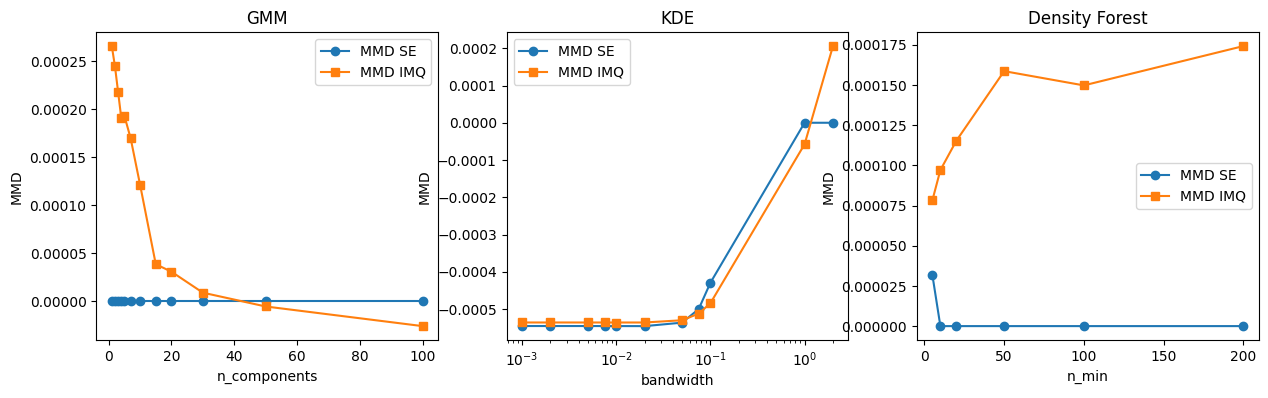

In [ ]:

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

ax = axes[0]
ax.plot(mmd_results['GMM']['parameters'], mmd_results['GMM']['mmd_se'],  marker='o', label='MMD SE')
ax.plot(mmd_results['GMM']['parameters'], mmd_results['GMM']['mmd_imq'], marker='s', label='MMD IMQ')
ax.set_xlabel('n_components'); ax.set_ylabel('MMD'); ax.set_title('GMM'); ax.legend()

ax = axes[1]
ax.plot(mmd_results['KDE']['parameters'], mmd_results['KDE']['mmd_se'],  marker='o', label='MMD SE')
ax.plot(mmd_results['KDE']['parameters'], mmd_results['KDE']['mmd_imq'], marker='s', label='MMD IMQ')
ax.set_xscale('log'); ax.set_xlabel('bandwidth'); ax.set_ylabel('MMD'); ax.set_title('KDE'); ax.legend()

ax = axes[2]
ax.plot(mmd_results['DF']['parameters'],  mmd_results['DF']['mmd_se'],   marker='o', label='MMD SE')
ax.plot(mmd_results['DF']['parameters'],  mmd_results['DF']['mmd_imq'],  marker='s', label='MMD IMQ')
ax.set_xlabel('n_min'); ax.set_ylabel('MMD'); ax.set_title('Density Forest'); ax.legend()
plt.show()

#### Digits is 64-D with pixel values ≈0–16. With the SE kernel and h=1.0, off-diagonal kernel values are ~0, so SE-MMD² stays near zero (tiny negatives are unbiased-estimator noise). The IMQ kernel decays slower, hence it’s informative.

### GMM:

As n_components increases, flexibility improves → IMQ-MMD² decreases and plateaus. SE stays ~0 due to the bandwidth issue.

### KDE:

Very small bandwidth → lowest MMD². Increasing bandwidth oversmooths → IMQ-MMD² rises sharply. SE shows the same trend but compressed near zero.

### Density Forest:

Larger n_min → larger leaves → higher bias → IMQ-MMD² increases with n_min. SE remains 0 (same reason).


In [ ]:
def select_models(res, model_name):
    mmd_scores = (np.array(res[model_name]['mmd_se']) + np.array(res[model_name]['mmd_imq'])) / 2
    best_idx = np.argmin(mmd_scores); worst_idx = np.argmax(mmd_scores)
    return (res[model_name]['model'][best_idx], res[model_name]['model'][worst_idx],
            res[model_name]['parameters'][best_idx], res[model_name]['parameters'][worst_idx])

gmm_good, gmm_bad, K_good, K_bad = select_models(mmd_results, 'GMM')
kde_good, kde_bad, h_good, h_bad = select_models(mmd_results, 'KDE')
df_good,  df_bad,  nmin_good, nmin_bad = select_models(mmd_results, 'DF')

def gen_samples(model, kind, n=test_size):
    if kind == 'GMM':
        s, _ = model.sample(n); return s
    elif kind == 'KDE':
        return model.sample(n, random_state=42)
    else:
        return model.sample(n)
    
samples_gmm_good = gen_samples(gmm_good, 'GMM')
samples_gmm_bad  = gen_samples(gmm_bad,  'GMM')
samples_kde_good = gen_samples(kde_good, 'KDE')
samples_kde_bad  = gen_samples(kde_bad,  'KDE')
samples_df_good  = gen_samples(df_good,  'DF')
samples_df_bad   = gen_samples(df_bad,   'DF')

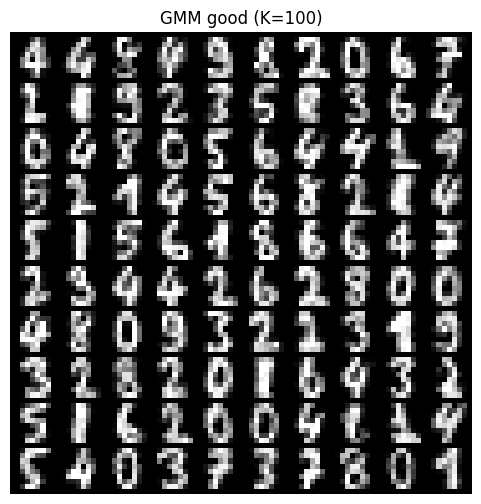

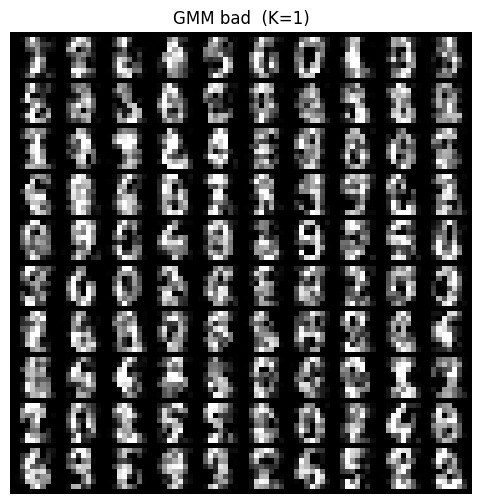

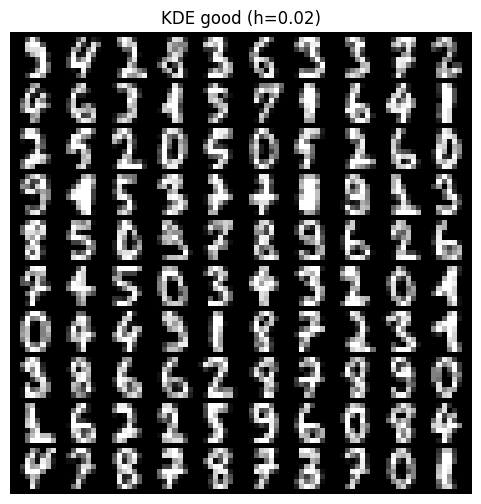

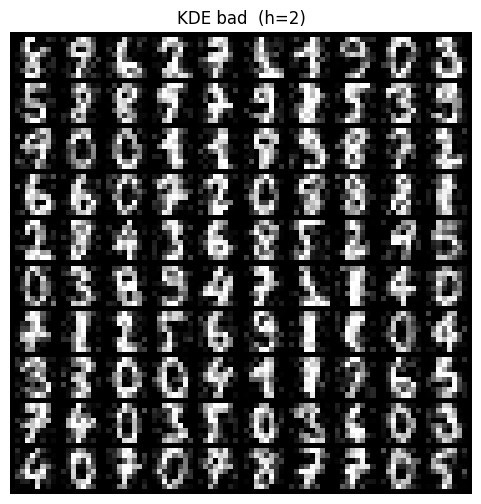

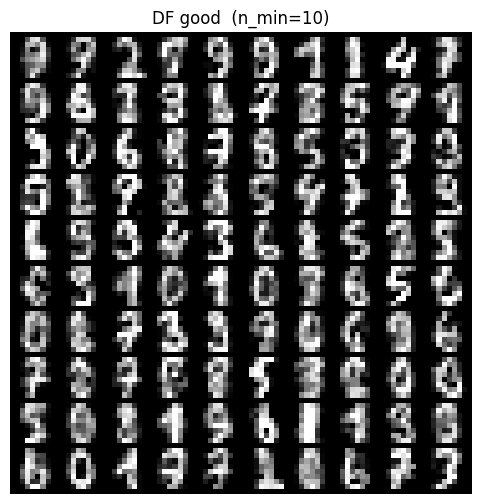

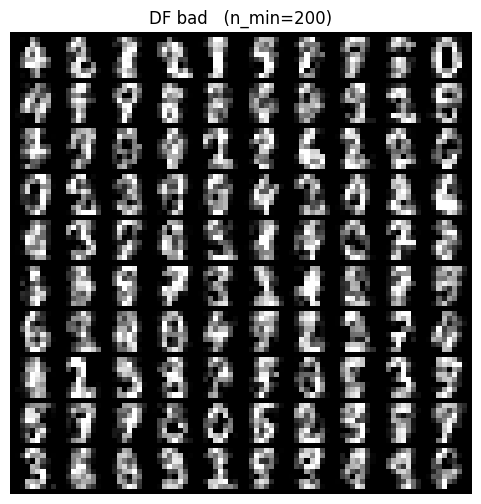

In [ ]:
def show_grid(samples, title, n=10):
    fig, ax = plt.subplots(figsize=(6,6))
    ax.set_title(title); ax.axis('off')
    d = 8
    canvas = np.zeros(((d+1)*n+1, (d+1)*n+1))
    pick = samples.copy()
    rng.shuffle(pick)
    for i in range(n):
        for j in range(n):
            img = pick[i*n + j].reshape(d, d)
            img = np.clip(img, 0, 16)
            canvas[i*(d+1)+1:(i+1)*(d+1), j*(d+1)+1:(j+1)*(d+1)] = img
    ax.imshow(canvas, cmap='gray')
    plt.show()

show_grid(samples_gmm_good, f"GMM good (K={K_good})")
show_grid(samples_gmm_bad,  f"GMM bad  (K={K_bad})")
show_grid(samples_kde_good, f"KDE good (h={h_good})")
show_grid(samples_kde_bad,  f"KDE bad  (h={h_bad})")
show_grid(samples_df_good,  f"DF good  (n_min={nmin_good})")
show_grid(samples_df_bad,   f"DF bad   (n_min={nmin_bad})")


#### Higher GMM capacity, KDE with a small bandwidth, and DF with small n_min produce sharper, more class-distinct digits, exactly what the IMQ-MMD² curves report. SE-MMD² being near zero is a bandwidthartifact (64-D digits with h=1).

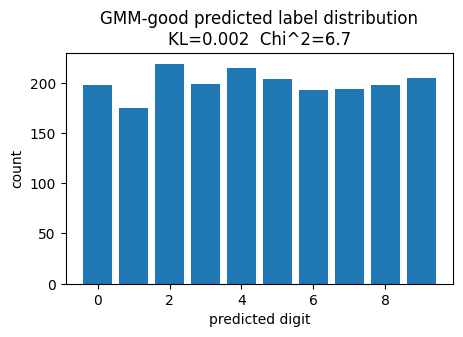

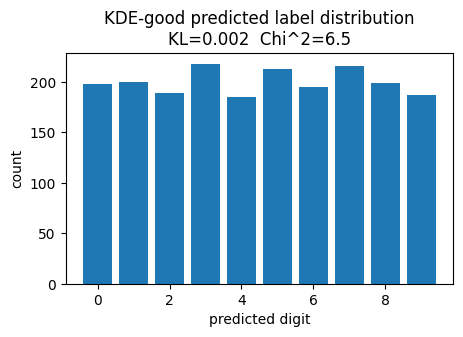

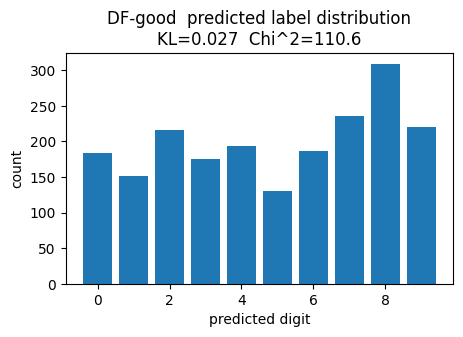

In [ ]:
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

def plot_label_hist(pred, title):
    counts = np.bincount(pred, minlength=10)
    p = counts / counts.sum()
    u = np.ones(10)/10
    from scipy.stats import entropy
    kl = entropy(p + 1e-12, u)    # KL(p||uniform)
    chi2 = ((counts - counts.mean())**2 / (counts.mean() + 1e-12)).sum()
    plt.figure(figsize=(5,3))
    plt.bar(range(10), counts)
    plt.title(f"{title}\nKL={kl:.3f}  Chi^2={chi2:.1f}")
    plt.xlabel("predicted digit"); plt.ylabel("count")
    plt.show()
    return counts

pred_gmm = rf.predict(samples_gmm_good)
pred_kde = rf.predict(samples_kde_good)
pred_df  = rf.predict(samples_df_good)

_ = plot_label_hist(pred_gmm, "GMM-good predicted label distribution")
_ = plot_label_hist(pred_kde, "KDE-good predicted label distribution")
_ = plot_label_hist(pred_df,  "DF-good  predicted label distribution")

#### GMM-good: 
Predicted label counts are close to uniform (≈200 per class). KL≈0.002, χ²≈6.7 → essentially balanced and recognisable.

#### KDE-good:
Also near uniform. KL≈0.002, χ²≈6.5 → balanced and recognisable, consistent with low MMD² at small bandwidth.

#### DF-good:
Strong class bias (e.g., 8/9 over-represented). KL≈0.027, χ²≈110.6 → clearly not generated in equal proportions, despite recognisable digits.

So, GMM and KDE (with good hyper-parameters) pass the “equal proportions” check; Density Forest does not.


In [ ]:
from collections import Counter
def balanced_batch_by_pred(samples,
                           clf,
                           per_class=100,
                           to_clf_space=None,
                           pool_size=None,
                           rng=None):

    rng = np.random.default_rng(0) if rng is None else rng

    X_pool = samples if pool_size is None else samples[:pool_size]

    X_for_clf = X_pool if to_clf_space is None else to_clf_space(X_pool)

    y_pred = clf.predict(X_for_clf)
    counts = Counter(y_pred.tolist())
    if len(counts) < 2:
        raise ValueError(f"All samples predicted as one class: {counts}. "
                         f"Check scaling: to_clf_space={to_clf_space is not None}")

    idxs = []
    for c in range(10):
        pool = np.where(y_pred == c)[0]
        if len(pool) == 0:
            continue
        take = rng.choice(pool, size=per_class, replace=(len(pool) < per_class))
        idxs.append(take)
    if not idxs:
        raise ValueError("No classes available for balancing. Check inputs.")
    idxs = np.concatenate(idxs)

    return X_for_clf[idxs], y_pred[idxs], counts

rf = RandomForestClassifier(n_estimators=200, random_state=42).fit(X_train, y_train)
bal_gmm, yb_gmm, cnt = balanced_batch_by_pred(samples_gmm_good, rf, per_class=10,to_clf_space=None)
bal_kde, yb_kde, cnt = balanced_batch_by_pred(samples_kde_good, rf, per_class=10,to_clf_space=None)
bal_df,  yb_df, cnt  = balanced_batch_by_pred(samples_df_good,  rf, per_class=10,to_clf_space=None)


In [ ]:
def show_grid_with_labels(samples, preds, title, n=10, vmax=16):
    import matplotlib.pyplot as plt
    d = 8
    fig, axes = plt.subplots(n, n, figsize=(8, 6)); fig.suptitle(title)
    for i in range(n):
        for j in range(n):
            k = i*n + j
            axes[i,j].imshow(np.clip(samples[k].reshape(d,d), 0, vmax),
                             cmap='gray', vmin=0, vmax=vmax)
            axes[i,j].axis('off')
            axes[i,j].text(1.25, 0.15, str(preds[k]), fontsize=12, color='black',
                           transform=axes[i,j].transAxes, ha='center', va='center')
    plt.show()


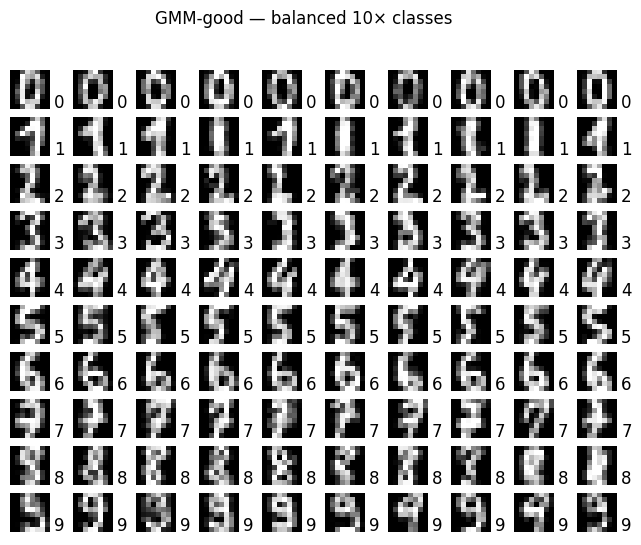

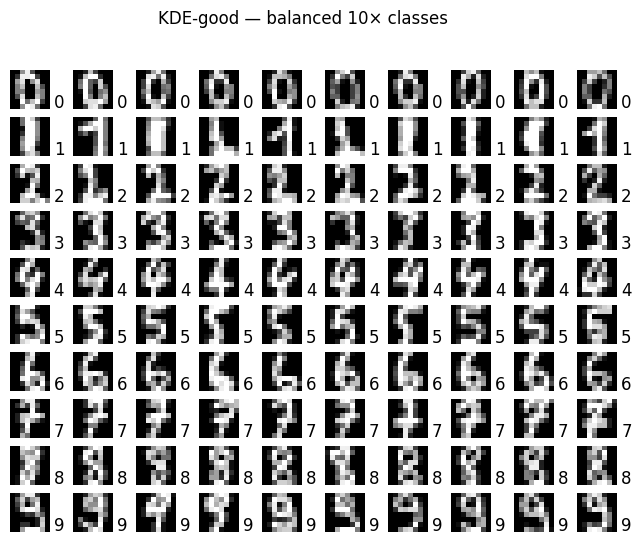

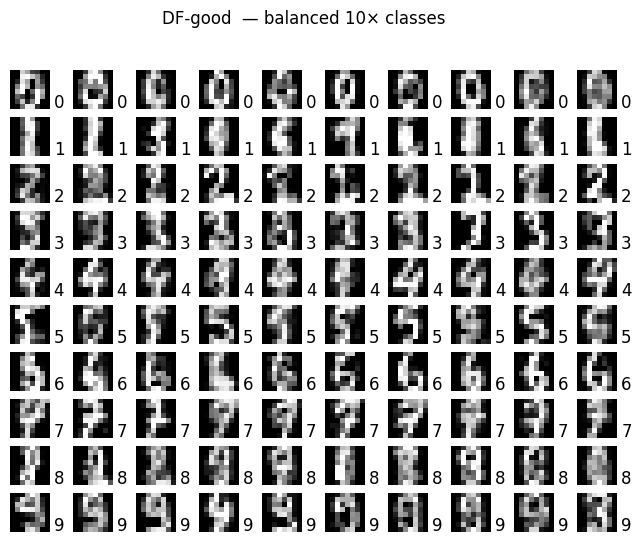

In [ ]:
if len(bal_gmm): show_grid_with_labels(bal_gmm, yb_gmm, "GMM-good — balanced 10× classes")
if len(bal_kde): show_grid_with_labels(bal_kde, yb_kde, "KDE-good — balanced 10× classes")
if len(bal_df):  show_grid_with_labels(bal_df,  yb_df,  "DF-good  — balanced 10× classes")